In [1]:
import cudf as pd
from tqdm.auto import tqdm

In [2]:
def import_labelled_data(path="data/level-0.5/data.json"):
    data = pd.read_json(path, encoding="latin-1")
    return data



print("Loading data...")

test_dataset = import_labelled_data(path="../../data/level-0.5/irrelevant.json", )

print("Data loaded.")


# test_dataset = test_dataset.sample(2500)

test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)


test_dataset.info()
test_dataset.head()

Loading data...


/workspace/GreyLit/venv/lib/python3.10/site-packages/cudf/io/json.py:108: UserWarning: Using CPU via Pandas to read JSON dataset, this may be GPU accelerated in the future
  warnings.warn(


Data loaded.
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 10688 entries, 0 to 10687
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   url           10688 non-null  object
 1   text          10688 non-null  object
 2   relevance     10688 non-null  object
 3   multiclasses  10688 non-null  list
dtypes: list(1), object(3)
memory usage: 1.3+ GB


,url,text,relevance,multiclasses
0,https://www.bpi.com.ph/content/dam/regulatory-...,Ill s•curttlea . . . . . . . IIEAD 41 !Ill• ex...,irrelevant,[]
1,https://deadliestwebattacks.com/assets/devops-...,"DevOps Is Automation, DevSecOps Is People Mike...",irrelevant,[]
2,https://zenodo.org/records/10679712/files/ELAI...,ELAION: ML-Based System for Olive Classiﬁcatio...,irrelevant,[]
3,http://wvumedicine.org/princeton/wp-content/up...,"February 2023 Rowena Chambers, MD, Retires Aft...",irrelevant,[]
4,https://repositorio.unfv.edu.pe/bitstream/hand...,Vicerrectorado de INVESTIGACIÓN ESCUELA UNIVER...,irrelevant,[]


In [3]:
from pickle import load

with open('models/LogisticRegression.pkl', 'rb') as file:
    classifier = load(file)

In [4]:
# prediction on 10688 articles takes 1m 0.4s

print(f'Estimated articles processed per second: {10688 / 60}')
print(f'Predicted time to predict {len(test_dataset)} articles: {60 / 10688 *len(test_dataset)} seconds')

predictions, probabilities = classifier.predict_threshold(test_dataset, threshold=0.5)

Estimated articles processed per second: 178.13333333333333
Predicted time to predict 10688 articles: 60.0 seconds


In [5]:

test_dataset['score'] = probabilities.get()[:,1]
test_dataset['prediction'] = classifier.boolPredictionsToLabels(predictions.get().astype(f'<U{len("irrelevant")}'))

test_dataset = test_dataset.sort_values(by='score', ascending=False)

In [9]:
test_dataset.info()
test_dataset.head()

<class 'cudf.core.dataframe.DataFrame'>
Index: 10688 entries, 10117 to 848
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   url           10688 non-null  object
 1   text          10688 non-null  object
 2   relevance     10688 non-null  object
 3   multiclasses  10688 non-null  list
 4   score         10688 non-null  float64
 5   prediction    10688 non-null  object
dtypes: float64(1), list(1), object(4)
memory usage: 1.3+ GB


,url,text,relevance,multiclasses,score,prediction
10117,https://digitalarchive.worldfishcenter.org/bit...,MARINE ECOLOGY PROGRESS SERIES Vol. 588: 85–10...,irrelevant,[],0.843850,relevant
8779,https://wsobirds.org/images/pdfs/BeyondBirdFee...,BEYOND THE BIRD FEEDER: Creating a Bird-Friend...,irrelevant,[],0.805893,relevant
10445,https://digitalarchive.worldfishcenter.org/bit...,"S t a From October 2006 to May 2008, The World...",irrelevant,[],0.770467,relevant
1385,https://cms.zsl.org/sites/default/files/2022-1...,CAFF Assessment Series Report September 2015 A...,irrelevant,[],0.694472,relevant
8668,https://wwjournal.org/wp-content/uploads/sites...,Western Wildlife 11:11–18 • 2024 Submitted: 18...,irrelevant,[],0.683714,relevant


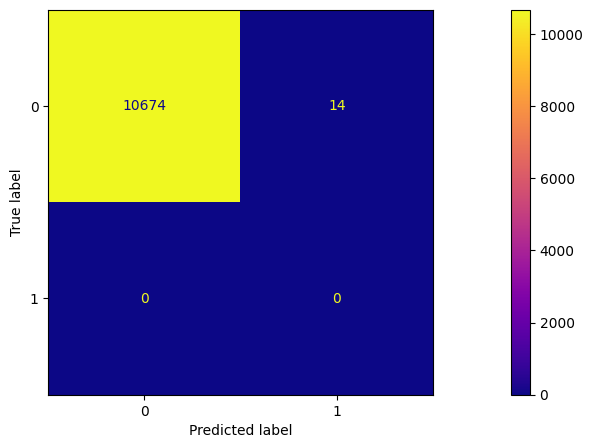

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 1, figsize=(20, 5))


confusion = confusion_matrix(test_dataset['relevance'].to_numpy(), test_dataset['prediction'].to_numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot(ax=axs, cmap='plasma')

plt.show()

In [20]:
def readjust_threshold(probabilities, threshold=0.5):
    return (probabilities > threshold).astype(f'<U{len("irrelevant")}').replace({'True': 'irrelevant', 'False': 'relevant'})

In [21]:
readjust_threshold(test_dataset['score'], threshold=0.5)

10117    irrelevant
8779     irrelevant
10445    irrelevant
1385     irrelevant
8668     irrelevant
            ...    
4583       relevant
10082      relevant
2538       relevant
8856       relevant
848        relevant
Name: score, Length: 10688, dtype: object

  0%|          | 0/1000 [00:00<?, ?it/s]

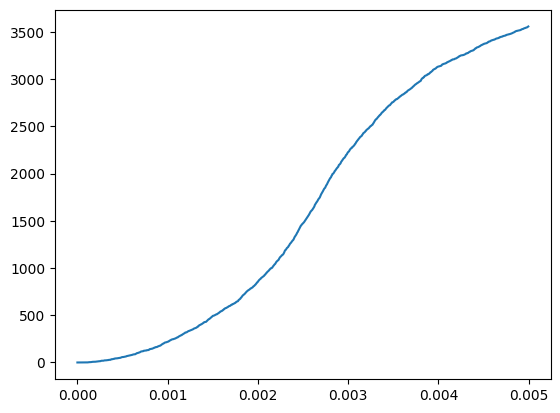

In [35]:
from numpy import arange
ranges = list(arange(0,0.005,0.00005))

relevants = []

for threshold in tqdm(ranges):
    new_predictions = readjust_threshold(test_dataset['score'], threshold=threshold)
    relevants.append(len(new_predictions[new_predictions == 'relevant']))

plt.plot(ranges, relevants)



In [8]:
# pd.options.display.max_colwidth = 200

display(test_dataset[['url', 'score', 'prediction']].head(10))
display(test_dataset['url'].head(10).to_numpy())

,url,score,prediction
10117,https://digitalarchive.worldfishcenter.org/bit...,0.843850,relevant
8779,https://wsobirds.org/images/pdfs/BeyondBirdFee...,0.805893,relevant
10445,https://digitalarchive.worldfishcenter.org/bit...,0.770467,relevant
1385,https://cms.zsl.org/sites/default/files/2022-1...,0.694472,relevant
8668,https://wwjournal.org/wp-content/uploads/sites...,0.683714,relevant
9911,http://www.wpcouncil.org/wp-content/uploads/20...,0.656541,relevant
6639,https://apps.worldagroforestry.org/downloads/P...,0.655423,relevant
778,https://zooreach.org/downloads/ZOO_CAMP_PHVA_r...,0.650072,relevant
8709,https://cms.zsl.org/sites/default/files/2022-1...,0.621324,relevant
8613,https://wos.org/documents/Publications/WA%20Bi...,0.577225,relevant


array(['https://digitalarchive.worldfishcenter.org/bitstream/handle/20.500.12348/692/4226.pdf?sequence=1&isAllowed=y',
       'https://wsobirds.org/images/pdfs/BeyondBirdFeederBookletFINAL.compressed.pdf',
       'https://digitalarchive.worldfishcenter.org/bitstream/handle/20.500.12348/1418/WF_2033.pdf?sequence=1&isAllowed=y',
       'https://cms.zsl.org/sites/default/files/2022-12/ASTI_MigBirds_Index_2015_0.pdf',
       'https://wwjournal.org/wp-content/uploads/sites/9/2024/06/Roy_etal_WW_2024.pdf',
       'http://www.wpcouncil.org/wp-content/uploads/2020/11/08.C1-Hutchinson-et-al-2021.pdf',
       'https://apps.worldagroforestry.org/downloads/Publications/PDFS/TM17693.pdf',
       'https://zooreach.org/downloads/ZOO_CAMP_PHVA_reports/2014-Reptile-Report.pdf',
       'https://cms.zsl.org/sites/default/files/2022-12/wildlife-comeback-in-europe.pdf',
       'https://wos.org/documents/Publications/WA%20Birds/2006/wabirds2006.pdf'],
      dtype=object)

In [10]:
display(test_dataset['url'].head(15).to_numpy())

array(['https://digitalarchive.worldfishcenter.org/bitstream/handle/20.500.12348/692/4226.pdf?sequence=1&isAllowed=y',
       'https://wsobirds.org/images/pdfs/BeyondBirdFeederBookletFINAL.compressed.pdf',
       'https://digitalarchive.worldfishcenter.org/bitstream/handle/20.500.12348/1418/WF_2033.pdf?sequence=1&isAllowed=y',
       'https://cms.zsl.org/sites/default/files/2022-12/ASTI_MigBirds_Index_2015_0.pdf',
       'https://wwjournal.org/wp-content/uploads/sites/9/2024/06/Roy_etal_WW_2024.pdf',
       'http://www.wpcouncil.org/wp-content/uploads/2020/11/08.C1-Hutchinson-et-al-2021.pdf',
       'https://apps.worldagroforestry.org/downloads/Publications/PDFS/TM17693.pdf',
       'https://zooreach.org/downloads/ZOO_CAMP_PHVA_reports/2014-Reptile-Report.pdf',
       'https://cms.zsl.org/sites/default/files/2022-12/wildlife-comeback-in-europe.pdf',
       'https://wos.org/documents/Publications/WA%20Birds/2006/wabirds2006.pdf',
       'https://dcprime.com/wp-content/uploads/2019/12/Po